## Q1

In [1]:
import torch

from sklearn.kernel_approximation import RBFSampler
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error#, peak_signal_noise_ratio
from sklearn import preprocessing
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()  # Convert from PyTorch tensor to NumPy
    X = rff.fit_transform(X)  # Transform with RFF
    return torch.tensor(X, dtype=torch.float32).to(device)

In [2]:
img = torchvision.io.read_image("dog.jpg")
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
image = crop.to(device)
H, W, C = image.shape
X, Y = np.meshgrid(np.arange(W), np.arange(H))
coords = np.vstack([X.ravel(), Y.ravel()]).T  # Flatten the coordinates
coords = torch.tensor(coords, dtype=torch.float32).to(device)  # Convert to PyTorch tensor
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(coords.cpu())
X_scaled = scaler_X.transform(coords.cpu())
X_scaled = torch.tensor(X_scaled).to(device)
X_scaled =X_scaled.float()
num_features =30000
sigma = 0.008
Z = create_rff_features(X_scaled, num_features, sigma)
print("created rrf")

created rrf


In [3]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)  # Linear layer for multiple outputs

    def forward(self, x):
        return self.linear(x)
def train_model(model, optimizer, Z, target, criterion, num_epochs=1000, print_interval=100):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad() 
        output = model(Z) 
        loss = criterion(output, target)
        loss.backward() 
        optimizer.step() 

        if epoch % print_interval == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')





In [4]:
input_size = Z.shape[1]
H, W, C = image.shape
image_flat = image.reshape(-1, C) 
target_tensor = torch.tensor(image_flat, dtype=torch.float32).to(device)
model = LinearRegressionModel(input_size, C).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
Z = Z.to(device)
train_model(model, optimizer, Z, target_tensor, criterion)


/tmp/ipykernel_36/2813537840.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(image_flat, dtype=torch.float32).to(device)


Epoch [0/1000], Loss: 0.372071
Epoch [100/1000], Loss: 0.000029
Epoch [200/1000], Loss: 0.000016
Epoch [300/1000], Loss: 0.000013
Epoch [400/1000], Loss: 0.000012
Epoch [500/1000], Loss: 0.000012
Epoch [600/1000], Loss: 0.000012
Epoch [700/1000], Loss: 0.000011
Epoch [800/1000], Loss: 0.000011
Epoch [900/1000], Loss: 0.000011


In [5]:
with torch.no_grad():
    reconstructed_flat = model(Z).cpu().numpy() 
    reconstructed_image = reconstructed_flat.reshape(H, W, C)



Reconstructed Image
RMSE: 0.0033, PSNR: 49.54 dB


/tmp/ipykernel_36/4005636488.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image_flat.cpu().numpy(), reconstructed_image_flat)


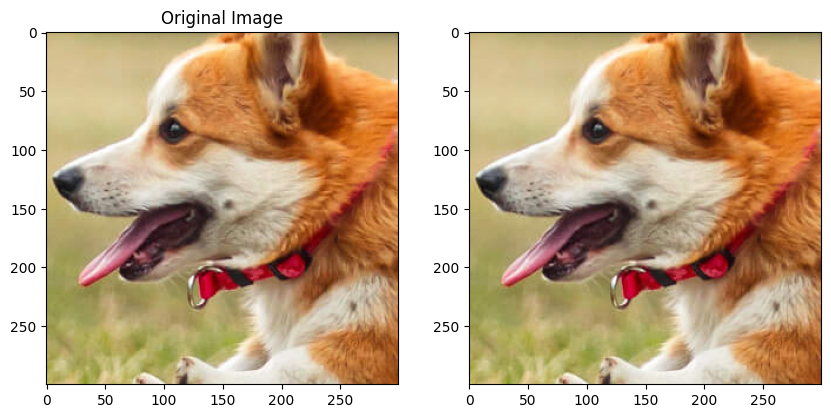

In [6]:
image_flat = image.ravel()
reconstructed_image_flat = reconstructed_image.ravel()

rmse = np.sqrt(mean_squared_error(image_flat.cpu().numpy(), reconstructed_image_flat))
psnr = peak_signal_noise_ratio(image_flat.cpu().numpy(), reconstructed_image_flat)
print((f"Reconstructed Image\nRMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB"))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rearrange(image[:3], 'c h w -> h w c').cpu().numpy())
#plt.imshow(image.cpu().numpy())
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(rearrange(reconstructed_image[:3], 'c h w -> h w c'))

## Q2

In [7]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
!pip install soundfile
import soundfile as sf
from IPython.display import Audio
# Load the audio file
audio_path = 'gt_bach.wav'
audio, sample_rate = librosa.load(audio_path, sr=None)  

In [8]:
audio = audio[-5 * sample_rate:]
audio_tensor = torch.tensor(audio, dtype=torch.float32).to(device)
audio_size = audio_tensor.shape
coords = torch.arange(audio_size[0], dtype=torch.float32).to(device)
coords = coords.reshape(-1, 1)

In [9]:
#scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(coords.cpu().numpy())
#X_scaled = scaler_X.transform(coords.cpu().numpy())
X_scaled = torch.tensor(coords, dtype=torch.float32).to(device)
X_scaled = X_scaled / X_scaled.max() * 200 - 100
num_features =5000
sigma = 0.008
Z = create_rff_features(X_scaled, num_features, sigma)
print("created rrf")

/tmp/ipykernel_36/1224967790.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled = torch.tensor(coords, dtype=torch.float32).to(device)


created rrf


In [17]:
def signaltonoise(xi, xr):
    noise = xi - xr
    signal_rssq = np.sqrt(np.mean(np.square(xi)))
    noise_rssq = np.sqrt(np.mean(np.square(noise)))
    snr_value = 20 * np.log10(signal_rssq / noise_rssq)
    
    return snr_value


In [11]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(Z.cpu(), audio)

pred_audio = model.predict(Z.cpu())
print(pred_audio.shape)

(220500,)


In [27]:
Audio(audio, rate = sample_rate)

In [28]:
Audio(pred_audio, rate = sample_rate)

In [29]:
sf.write('pred_audio.wav', pred_audio, sample_rate)

In [18]:
rmse = np.sqrt(mean_squared_error(audio, pred_audio))
snr=signaltonoise(audio,pred_audio)
print(f"Reconstructed Audio Waveform\nRMSE: {rmse:.4f}, SNR: {snr:.6f} dB")

Reconstructed Audio Waveform
RMSE: 0.1339, SNR: 2.330503 dB


In [19]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

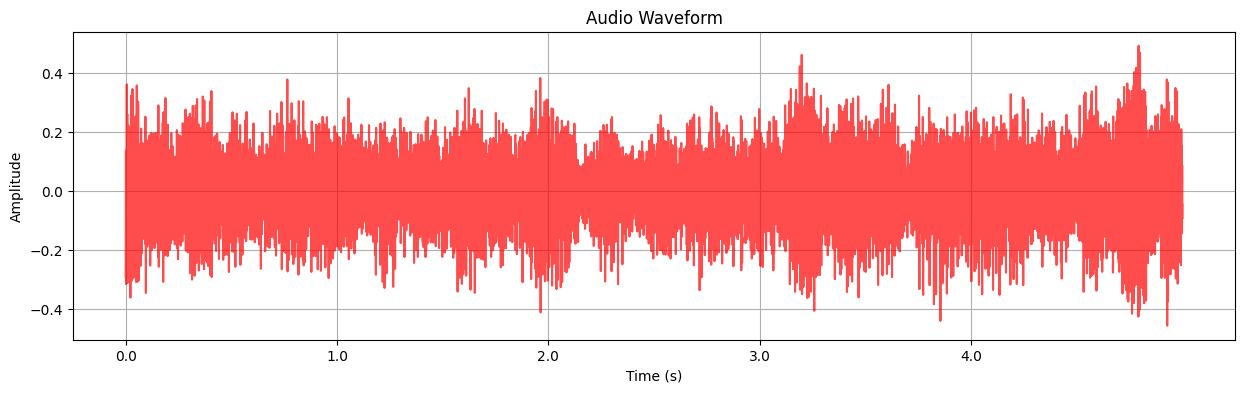

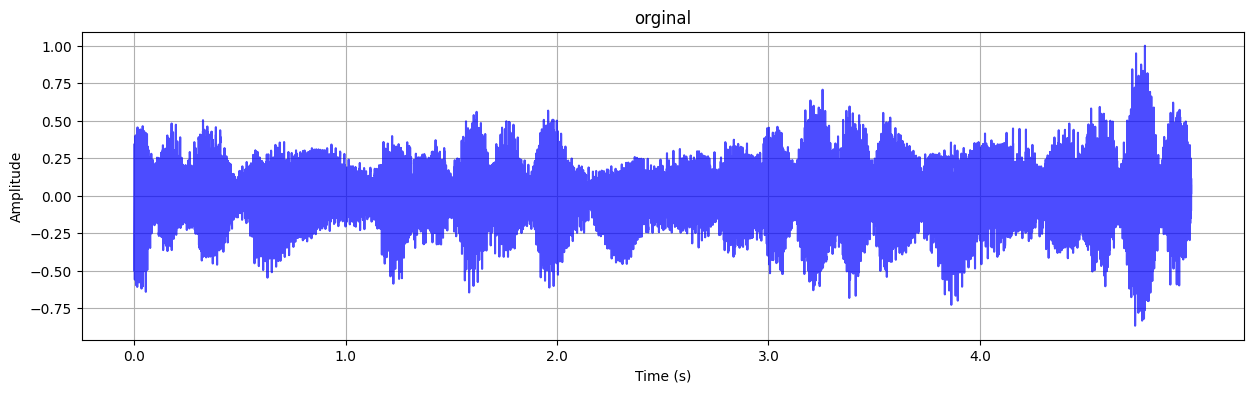

In [20]:
audio_plot(pred_audio, sample_rate, 'red', 'Audio Waveform')
audio_plot(audio,sample_rate,'blue','orginal')

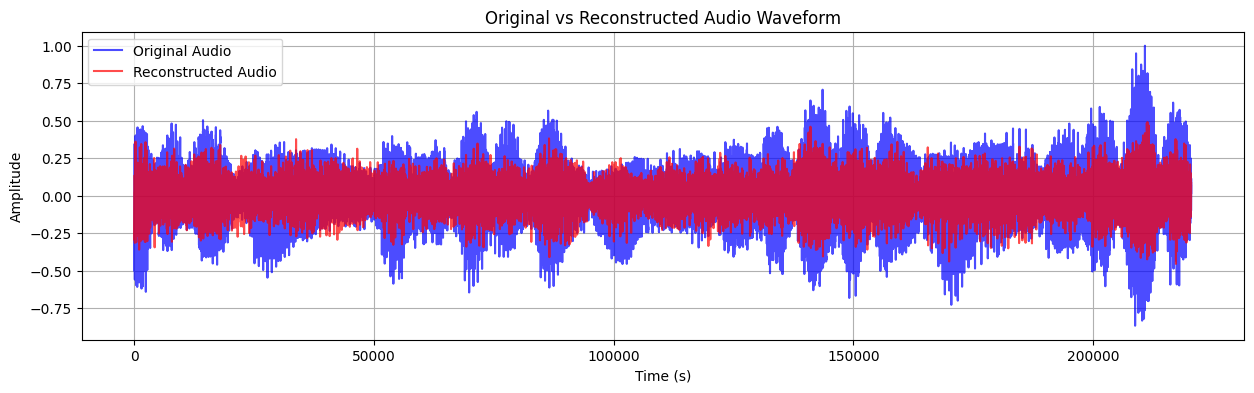

In [21]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [22]:
start_idx = 20000
end_idx = 30000

Z1 = Z[:start_idx]
Z2 = Z[end_idx:]

audio1 = audio_tensor[:start_idx]
audio2 = audio_tensor[end_idx:]
audioF = torch.cat((audio1, audio2), dim = 0)
ZF = torch.cat((Z1.cpu(), Z2.cpu()), dim = 0)
model = LinearRegression()
model.fit(ZF.cpu(), audioF.cpu())
pred_audio_del = model.predict(Z.cpu())
print(pred_audio_del.shape)



(220500,)


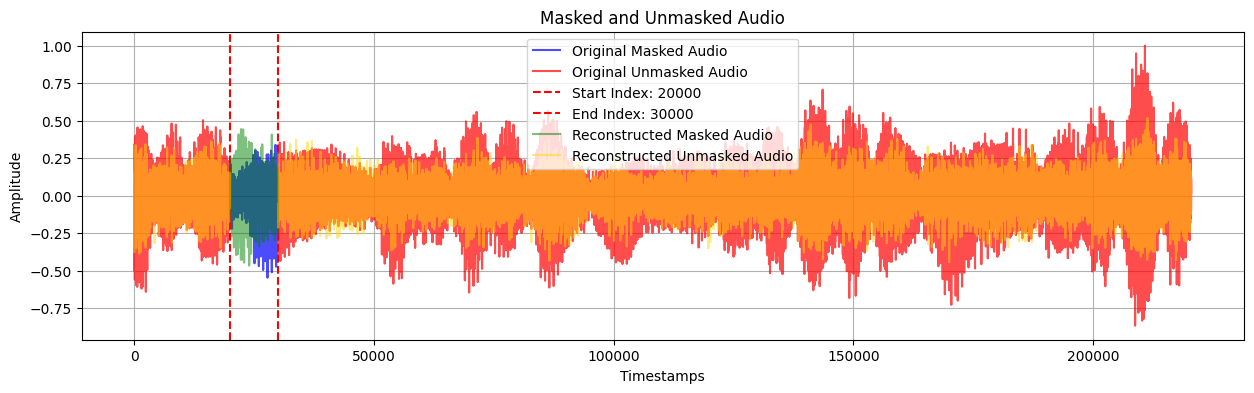

In [23]:
plt.figure(figsize=(15, 4))
plt.plot(np.arange(start_idx,end_idx), audio[start_idx:end_idx], color = 'blue', alpha = 0.7, label = 'Original Masked Audio')
plt.plot(np.arange(start_idx), audio[:start_idx], color = 'red', alpha = 0.7, label = 'Original Unmasked Audio')
plt.plot(np.arange(end_idx, X_scaled.shape[0]), audio[end_idx:], color = 'red', alpha = 0.7)

plt.axvline(start_idx, color = 'red', linestyle = '--', label = f'Start Index: {start_idx}')
plt.axvline(end_idx, color = 'red', linestyle = '--', label = f'End Index: {end_idx}')

plt.plot(np.arange(start_idx,end_idx), pred_audio_del[start_idx : end_idx], color = 'green', alpha = 0.5, label = 'Reconstructed Masked Audio')
plt.plot(np.arange(start_idx), pred_audio_del[:start_idx], color = 'gold', alpha = 0.5, label = 'Reconstructed Unmasked Audio')
plt.plot(np.arange(end_idx, X_scaled.shape[0]), pred_audio_del[end_idx:], color = 'gold', alpha = 0.5)

plt.xlabel('Timestamps')
plt.ylabel('Amplitude')
plt.title('Masked and Unmasked Audio')
plt.grid()
plt.legend()
plt.show()

In [25]:
rmse= np.sqrt(mean_squared_error(audio,pred_audio_del))
snr=signaltonoise(audio,pred_audio_del)
print(f"Reconstructed Audio Waveform\nRMSE: {rmse:.4f}, SNR: {snr:.6f} dB")

Reconstructed Audio Waveform
RMSE: 0.1374, SNR: 2.109490 dB


In [37]:
sf.write('pred_audio_deleted.wav', pred_audio_del, sample_rate)